# Lab 7 - Non-Linear Modeling

In [45]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

%matplotlib inline

In [36]:
# load dataset
wage = pd.read_csv('./datasets/wage.csv')

In [44]:
# inspect data
wage.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


## 7.8.1: Polynomial Regression and Step Functions

**Polynomial Regression**

In [38]:
# polynomial model of degree 4 with age feature
X4 = PolynomialFeatures(4).fit_transform(wage['age'].values.reshape(-1,1))

In [39]:
# create model
model4 = sm.GLS(wage['wage'],X4).fit()
model4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


In [40]:
# other candidates
X1 = PolynomialFeatures(1).fit_transform(wage['age'].values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(wage['age'].values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(wage['age'].values.reshape(-1,1))
X5 = PolynomialFeatures(4).fit_transform(wage['age'].values.reshape(-1,1))

In [41]:
# create models
model1 = sm.GLS(wage['wage'],X1).fit()
model2 = sm.GLS(wage['wage'],X2).fit()
model3 = sm.GLS(wage['wage'],X3).fit()
model5 = sm.GLS(wage['wage'],X5).fit()

In [46]:
# compare models
sm.stats.anova_lm(model1, model2, model3, model4, model5, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.602458,2.353254e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.889400,1.678616e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.810061,5.103865e-02
4,2995.0,4.771604e+06,-0.0,-0.000000,NaN,NaN


We select the X4 set as the best choice.

In [53]:
# create test data
age_grid = np.arange(wage['age'].min(), wage['age'].max()).reshape(-1,1)

In [65]:
# make predictions for Pr(wage>205)
y = (wage['wage'] > 250).map({False:0, True:1}).values

clf = sm.GLM(y, X4, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

X_test = PolynomialFeatures(4).fit_transform(age_grid)
pred = res.predict(X_test)

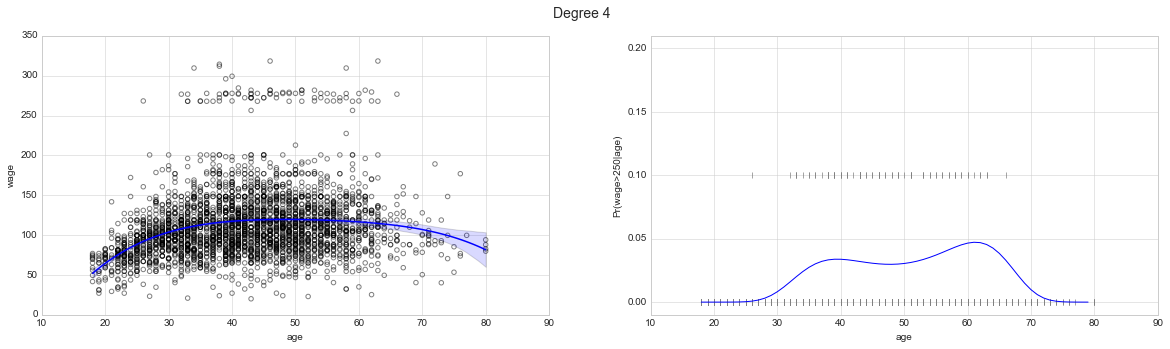

In [76]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
fig.suptitle('Degree 4',fontsize=14)

# plot existing data
ax1.scatter(wage['age'],wage['wage'],alpha=0.5,facecolor='None',edgecolor='k')
# plot polynomial regression
sns.regplot(wage['age'],wage['wage'],order=4,scatter=False,ax=ax1,truncate=True)
ax1.set_ylim(ymin=0)

# plot the logistic regression based on Pr(wage>250 | age)
ax2.plot(age_grid,pred,c='b')
ax2.scatter(wage['age'], y/10, s=30, c='grey', marker='|', alpha=0.7)
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

**Step Function**

In [82]:
# create cuts
wage_cut, bins = pd.cut(wage['age'],bins=4,retbins=True, right=True)
wage_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [107]:
# concatenate the features and the results of the binning
wage_steps = pd.concat([wage['age'],wage_cut,wage['wage']],keys=['age','age_cut','wage'],axis=1)

# create dummies
wage_steps = pd.get_dummies(wage_steps,columns=['age_cut'])

# a constant is requiered in statsmodels
wage_steps = sm.add_constant(wage_steps)
wage_steps.head()

,const,age,wage,"age_cut_(17.938, 33.5]","age_cut_(33.5, 49.0]","age_cut_(49.0, 64.5]","age_cut_(64.5, 80.0]"
0,1.0,18,75.043154,1,0,0,0
1,1.0,24,70.476020,1,0,0,0
2,1.0,45,130.982177,0,1,0,0
3,1.0,43,154.685293,0,1,0,0
4,1.0,50,75.043154,0,0,1,0


In [130]:
# create model
model = sm.GLM(wage_steps['wage'],wage_steps.drop(['age','wage','age_cut_(17.938, 33.5]'],axis=1)).fit()
model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"age_cut_(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"age_cut_(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"age_cut_(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


In [131]:
wage_steps[wage_steps.columns.difference(['age','wage','age_cut_(17.938, 33.5]'])].head()

,"age_cut_(33.5, 49.0]","age_cut_(49.0, 64.5]","age_cut_(64.5, 80.0]",const
0,0,0,0,1.0
1,0,0,0,1.0
2,1,0,0,1.0
3,1,0,0,1.0
4,0,1,0,1.0


In [132]:
# binthe test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [133]:
# get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_test2.columns = ['const','age_cut_(33.5, 49.0]','age_cut_(49.0, 64.5]','age_cut_(64.5, 80.0]']
X_test2.head()

,const,"age_cut_(33.5, 49.0]","age_cut_(49.0, 64.5]","age_cut_(64.5, 80.0]"
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,0,0,0
3,1.0,0,0,0
4,1.0,0,0,0


In [144]:
clf2 = sm.GLM(y, wage_steps.drop(['age','wage','age_cut_(17.938, 33.5]'],axis=1),
              family=sm.families.Binomial(sm.families.links.logit))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

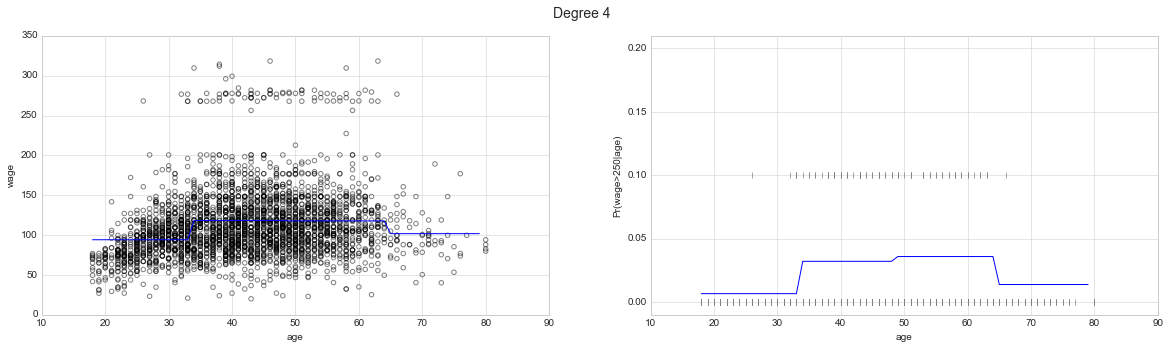

In [148]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
fig.suptitle('Degree 4',fontsize=14)

# plot existing data
ax1.scatter(wage['age'],wage['wage'],alpha=0.5,facecolor='None',edgecolor='k')
# plot step regression
ax1.plot(age_grid, pred2, c='b')
ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# plot the logistic regression based on Pr(wage>250 | age)
ax2.plot(np.arange(wage['age'].min(), wage['age'].max()).reshape(-1,1), pred3, color='b')
ax2.scatter(wage['age'], y/10, s=30, c='grey', marker='|', alpha=0.7)
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');